In [1]:
# Manipulation and Visualasation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
# Libraries for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, f1_score, precision_score, recall_score,roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')

In [3]:
### Shape of Dataset
print(f"The dataset has {data.shape[0]} Rows and {data.shape[1]} columns")

The dataset has 7043 Rows and 21 columns


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 6576 entries, SeniorCitizen to Churn_Yes
dtypes: float64(6574), int64(2)
memory usage: 353.4 MB


In [4]:
### Descriptive Analysis
data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [5]:
### Duplicated Values
data[data.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [6]:
data.groupby(['Churn','gender'])['gender'].count()

Churn  gender
No     Female    2549
       Male      2625
Yes    Female     939
       Male       930
Name: gender, dtype: int64

In [7]:
data.drop(['customerID'],axis=1,inplace=True)
columns = data.select_dtypes(include=['category','object']).columns
columns

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
### Transform Object Columns into Numbers
label_encoder = LabelEncoder()
data2 = data.copy()
for col in columns:
    data2[col] = label_encoder.fit_transform(data2[col])
data2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,925,1


In [22]:
print(data.columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No',
       ...
       'TotalCharges_996.45', 'TotalCharges_996.85', 'TotalCharges_996.95',
       'TotalCharges_997.65', 'TotalCharges_997.75', 'TotalCharges_998.1',
       'TotalCharges_999.45', 'TotalCharges_999.8', 'TotalCharges_999.9',
       'Churn_Yes'],
      dtype='object', length=6576)


In [28]:
columns = [col for col in columns if col in data.columns]
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_data = onehot_encoder.fit_transform(data[columns])
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(columns))
data = data.drop(columns, axis=1)
data = pd.concat([data, encoded_df], axis=1)
if 'Churn_No' in data.columns:
    data.drop('Churn_No', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()


,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9,Churn_Yes
0,0,1,29.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,34,56.95,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,53.85,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,45,42.30,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,70.70,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
### Show Correlation
corr = data2.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.006739,-0.000863,-0.015017,-0.012057,0.000549,-0.006825,-0.006421,-0.008743,0.000126,-0.011754,0.017352,-0.014569,-0.005291,-0.008612
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.146185,-0.032310,-0.128221,-0.013632,-0.021398,-0.151268,0.030776,0.047266,-0.142554,0.156530,-0.038551,0.220173,0.037653,0.150889
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142410,0.000891,0.150828,0.153130,0.166330,0.126733,0.137341,0.129574,0.294806,-0.014877,-0.154798,0.096848,0.059568,-0.150448
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024991,0.044590,0.152166,0.091015,0.080537,0.133524,0.046885,0.021321,0.243187,-0.111377,-0.040292,-0.113890,-0.009572,-0.164221
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.343032,-0.030359,0.325468,0.370876,0.371105,0.322942,0.289373,0.296866,0.671607,0.006152,-0.370436,0.247900,0.158523,-0.352229
PhoneService,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,-0.020538,0.387436,-0.015198,0.024105,0.003727,-0.019158,0.055353,0.043870,0.002247,0.016505,-0.004184,0.247398,0.083195,0.011942
MultipleLines,-0.006739,0.146185,0.142410,-0.024991,0.343032,-0.020538,1.000000,-0.109216,0.007141,0.117327,0.122318,0.011466,0.175059,0.180957,0.110842,0.165146,-0.176793,0.433576,0.114955,0.038037
InternetService,-0.000863,-0.032310,0.000891,0.044590,-0.030359,0.387436,-0.109216,1.000000,-0.028416,0.036138,0.044944,-0.026047,0.107417,0.098350,0.099721,-0.138625,0.086140,-0.323260,-0.055724,-0.047291
OnlineSecurity,-0.015017,-0.128221,0.150828,0.152166,0.325468,-0.015198,0.007141,-0.028416,1.000000,0.185126,0.175985,0.285028,0.044669,0.055954,0.374416,-0.157641,-0.096726,-0.053878,0.042357,-0.289309
OnlineBackup,-0.012057,-0.013632,0.153130,0.091015,0.370876,0.024105,0.117327,0.036138,0.185126,1.000000,0.187757,0.195748,0.147186,0.136722,0.280980,-0.013370,-0.124847,0.119777,0.090756,-0.195525


In [30]:
target_corr = corr[['Churn']].drop('Churn')
target_corr

,Churn
gender,-0.008612
SeniorCitizen,0.150889
Partner,-0.150448
Dependents,-0.164221
tenure,-0.352229
PhoneService,0.011942
MultipleLines,0.038037
InternetService,-0.047291
OnlineSecurity,-0.289309
OnlineBackup,-0.195525


In [31]:
### Split 
X = data.drop(['Churn_Yes'],axis=1)
y = data['Churn_Yes']
keys = X.columns
X.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,34,56.95,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,53.85,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,45,42.30,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,70.70,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
data.dtypes


SeniorCitizen            int64
tenure                   int64
MonthlyCharges         float64
gender_Female          float64
gender_Male            float64
                        ...   
TotalCharges_998.1     float64
TotalCharges_999.45    float64
TotalCharges_999.8     float64
TotalCharges_999.9     float64
Churn_Yes              float64
Length: 6576, dtype: object

In [33]:
mask = np.triu(np.ones_like(target_corr, dtype=bool))
df_mask = target_corr.mask(mask)
df_mask_rounded = df_mask.round(2)
fig = ff.create_annotated_heatmap(
    z=df_mask_rounded.values,
    x=['Churn'],
    y=df_mask_rounded.index.tolist(),
    colorscale='RdBu',
    hoverinfo='none',
    showscale=True,
    ygap=1,
    xgap=1
)
fig.update_xaxes(side='bottom')
fig.update_layout(
    title_text='Correlation with Churn',
    title_font=dict(size=20, color='red'),
    title_x=0.5,
    width=1000,
    height=700,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True, autorange='reversed'),
    template='plotly_dark'
)
for annotation in fig.layout.annotations:
    if annotation.text == 'nan':
        annotation.text = ""

fig.show()

In [34]:
y.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: Churn_Yes, dtype: float64

In [35]:
scale = MinMaxScaler()
X = scale.fit_transform(X)
X = pd.DataFrame(X,columns=keys)
X.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0.0,0.013889,0.115423,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.472222,0.385075,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.027778,0.354229,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.625000,0.239303,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                            random_state=42, shuffle =True,stratify=y)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (5634, 6575)
X_test shape is  (1409, 6575)
y_train shape is  (5634,)
y_test shape is  (1409,)


In [21]:
# Apply SMOTEN to the training data
smoten = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoten.fit_resample(X, y)
# Print the shapes after applying SMOTEN
print('X_resampled shape is ', X_resampled.shape)
print('y_resampled shape is ', y_resampled.shape)

X_resampled shape is  (6833, 6575)
y_resampled shape is  (6833,)


In [39]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled,
                                                                           test_size=0.20,random_state=42, shuffle =True,stratify=y_resampled)
print('X_train_resampled shape is ' , X_train_resampled.shape)
print('X_test_resampled shape is ' , X_test_resampled.shape)
print('y_train_resampled shape is ' , y_train_resampled.shape)
print('y_test_resampled shape is ' , y_test_resampled.shape)

X_train_resampled shape is  (5466, 6575)
X_test_resampled shape is  (1367, 6575)
y_train_resampled shape is  (5466,)
y_test_resampled shape is  (1367,)


In [40]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(),
    'LGBM': LGBMClassifier(verbose=-1),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=42, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(logging_level='Silent'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'NaiveBayes': GaussianNB()
}
### Validation Score
cv_results = {}
for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,verbose=0)
    cv_results[model_name] = cv_scores.mean()
    print(f"Mean accuracy for {model_name}: {cv_scores.mean():.4f}")

Cross-validating RandomForest...
Mean accuracy for RandomForest: 0.7888
Cross-validating XGBoost...
Mean accuracy for XGBoost: 0.7803
Cross-validating LGBM...
Mean accuracy for LGBM: 0.7914
Cross-validating DecisionTree...
Mean accuracy for DecisionTree: 0.7709
Cross-validating KNN...
Mean accuracy for KNN: 0.7659
Cross-validating SVC...
Mean accuracy for SVC: 0.7377
Cross-validating LogisticRegression...
Mean accuracy for LogisticRegression: 0.7645
Cross-validating CatBoost...
Mean accuracy for CatBoost: 0.8049
Cross-validating GradientBoosting...
Mean accuracy for GradientBoosting: 0.8032
Cross-validating AdaBoost...
Mean accuracy for AdaBoost: 0.8010
Cross-validating NaiveBayes...
Mean accuracy for NaiveBayes: 0.2803


In [41]:
cv_results_df = pd.DataFrame(list(cv_results.items()), columns=['Model', 'Mean Accuracy'])
cv_results_df = cv_results_df.sort_values(by='Mean Accuracy', ascending=False)
cv_results_df

,Model,Mean Accuracy
7,CatBoost,0.804932
8,GradientBoosting,0.803157
9,AdaBoost,0.801027
2,LGBM,0.791442
0,RandomForest,0.788782
1,XGBoost,0.780259
3,DecisionTree,0.770853
4,KNN,0.765882
6,LogisticRegression,0.764461
5,SVC,0.737658


In [42]:
# Apply ML in SMOTEN to the training data
### Validation Score 
cv_results = {}
for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy', n_jobs=-1,verbose=0)
    cv_results[model_name] = cv_scores.mean()
    print(f"Mean accuracy for {model_name}: {cv_scores.mean():.4f}")

Cross-validating RandomForest...
Mean accuracy for RandomForest: 0.9727
Cross-validating XGBoost...
Mean accuracy for XGBoost: 0.9676
Cross-validating LGBM...
Mean accuracy for LGBM: 0.9643
Cross-validating DecisionTree...
Mean accuracy for DecisionTree: 0.9537
Cross-validating KNN...
Mean accuracy for KNN: 0.9493
Cross-validating SVC...
Mean accuracy for SVC: 0.9526
Cross-validating LogisticRegression...
Mean accuracy for LogisticRegression: 0.9398
Cross-validating CatBoost...
Mean accuracy for CatBoost: 0.9548
Cross-validating GradientBoosting...
Mean accuracy for GradientBoosting: 0.9486
Cross-validating AdaBoost...
Mean accuracy for AdaBoost: 0.9475
Cross-validating NaiveBayes...
Mean accuracy for NaiveBayes: 0.9715


In [43]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Define scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

cv_results = {}

for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    # Use cross_validate to get multiple scores
    cv_scores = cross_validate(model, X_train_resampled, y_train_resampled, cv=5, 
                               scoring=scoring_metrics, n_jobs=-1, verbose=0)
    
    # Calculate mean scores for each metric
    mean_accuracy = cv_scores['test_accuracy'].mean()
    mean_f1 = cv_scores['test_f1'].mean()
    mean_precision = cv_scores['test_precision'].mean()
    mean_recall = cv_scores['test_recall'].mean()
    
    # Store results
    cv_results[model_name] = {
        'accuracy': mean_accuracy,
        'f1_score': mean_f1,
        'precision': mean_precision,
        'recall': mean_recall
    }
    
    # Print results
    print(f"Mean scores for {model_name}:")
    print(f"  Accuracy: {mean_accuracy:.4f}")
    print(f"  F1 Score: {mean_f1:.4f}")
    print(f"  Precision: {mean_precision:.4f}")
    print(f"  Recall: {mean_recall:.4f}")



Cross-validating RandomForest...
Mean scores for RandomForest:
  Accuracy: 0.9727
  F1 Score: 0.9797
  Precision: 0.9769
  Recall: 0.9825
Cross-validating XGBoost...
Mean scores for XGBoost:
  Accuracy: 0.9676
  F1 Score: 0.9759
  Precision: 0.9739
  Recall: 0.9779
Cross-validating LGBM...
Mean scores for LGBM:
  Accuracy: 0.9643
  F1 Score: 0.9735
  Precision: 0.9705
  Recall: 0.9765
Cross-validating DecisionTree...
Mean scores for DecisionTree:
  Accuracy: 0.9537
  F1 Score: 0.9657
  Precision: 0.9596
  Recall: 0.9719
Cross-validating KNN...
Mean scores for KNN:
  Accuracy: 0.9493
  F1 Score: 0.9634
  Precision: 0.9346
  Recall: 0.9940
Cross-validating SVC...
Mean scores for SVC:
  Accuracy: 0.9526
  F1 Score: 0.9646
  Precision: 0.9666
  Recall: 0.9626
Cross-validating LogisticRegression...
Mean scores for LogisticRegression:
  Accuracy: 0.9398
  F1 Score: 0.9550
  Precision: 0.9577
  Recall: 0.9522
Cross-validating CatBoost...
Mean scores for CatBoost:
  Accuracy: 0.9548
  F1 Score

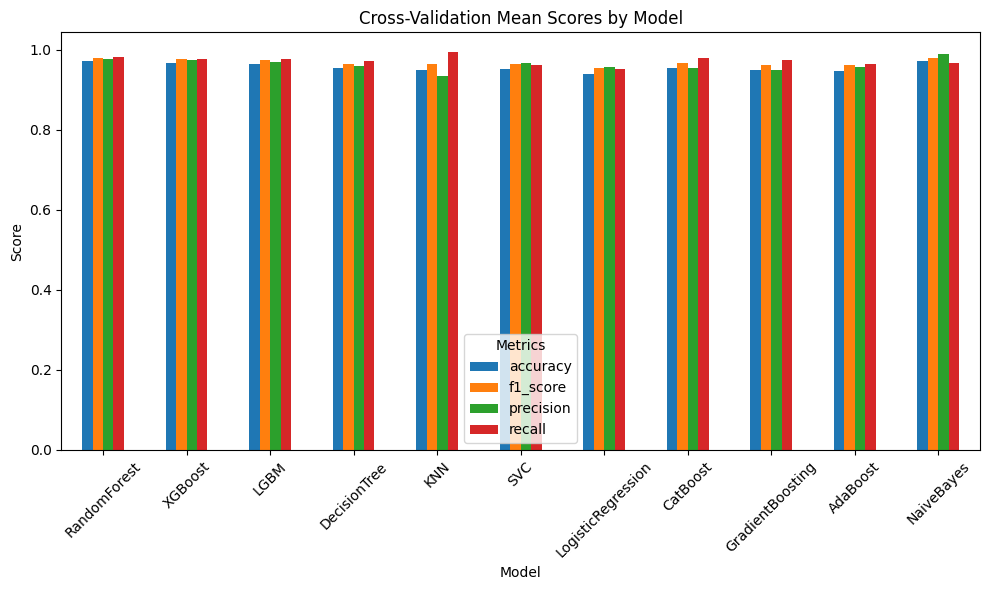

In [44]:
# Convert cv_results dictionary to a DataFrame for easier plotting
results_df = pd.DataFrame(cv_results).T  # Transpose for easier access

# Plot each metric in a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bar chart
results_df.plot(kind='bar', ax=ax)
ax.set_title("Cross-Validation Mean Scores by Model")
ax.set_ylabel("Score")
ax.set_xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metrics")

plt.tight_layout()
plt.show()

Training and evaluating RandomForest...


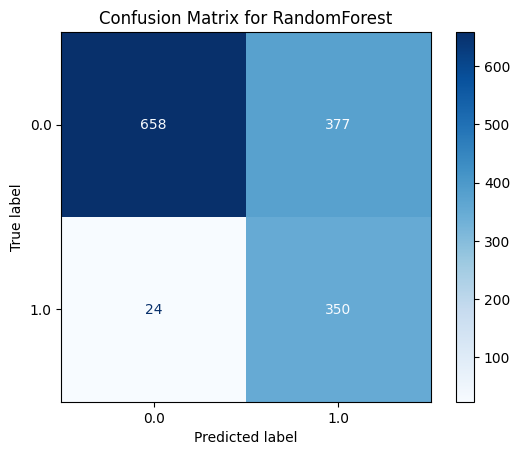

Training and evaluating XGBoost...


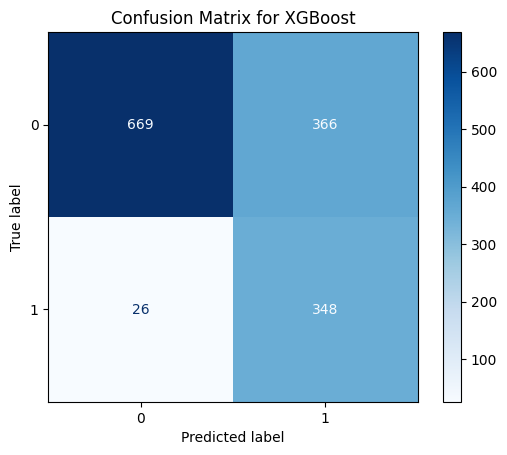

Training and evaluating LGBM...


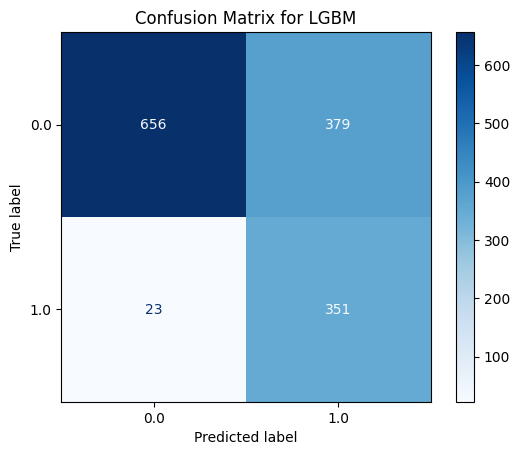

Training and evaluating DecisionTree...


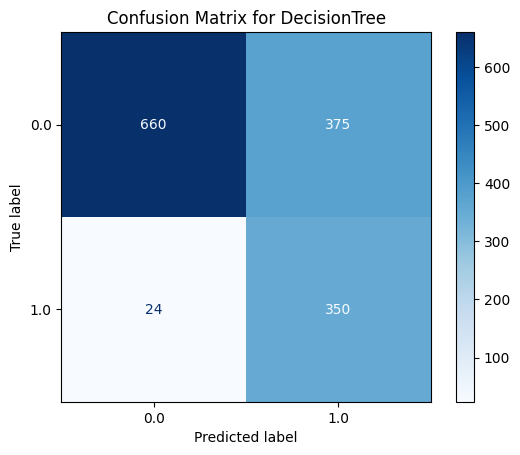

Training and evaluating KNN...


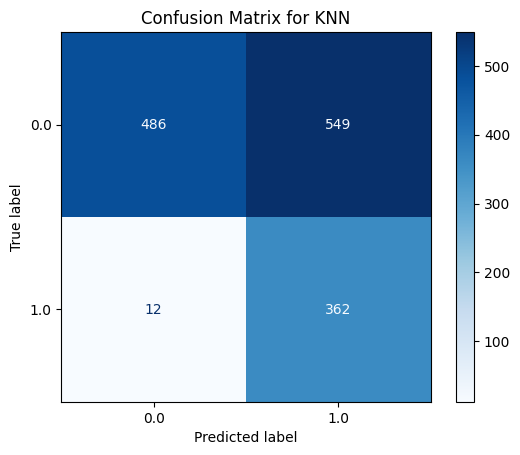

Training and evaluating SVC...


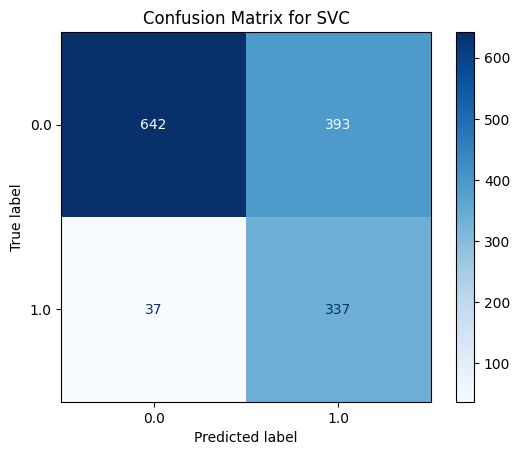

Training and evaluating LogisticRegression...


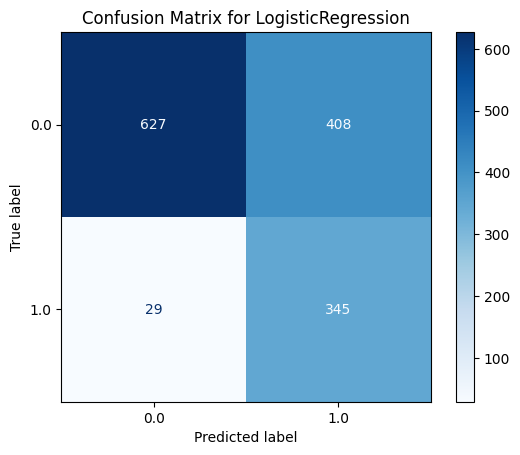

Training and evaluating CatBoost...


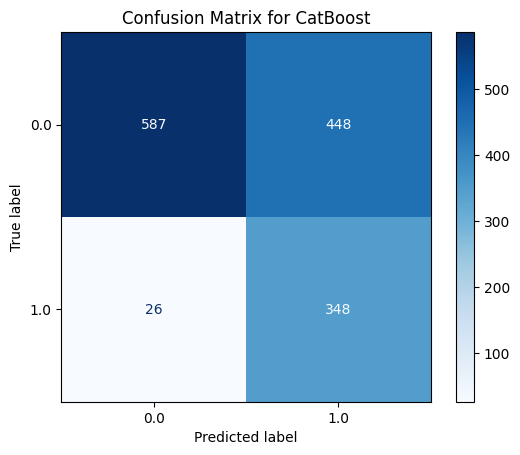

Training and evaluating GradientBoosting...


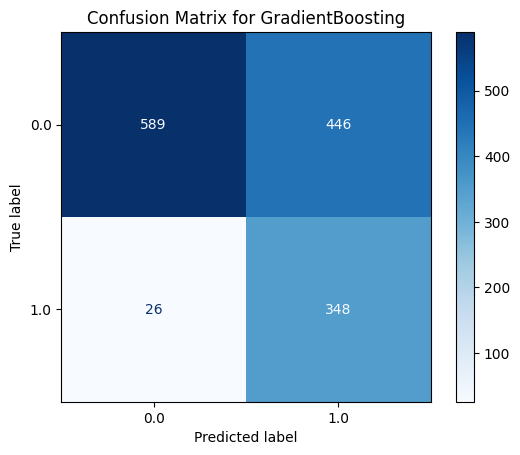

Training and evaluating AdaBoost...


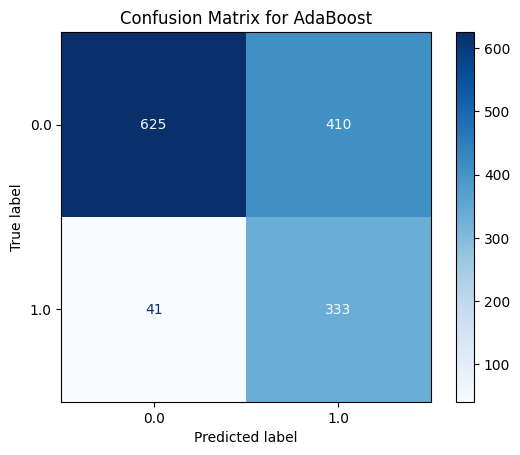

Training and evaluating NaiveBayes...


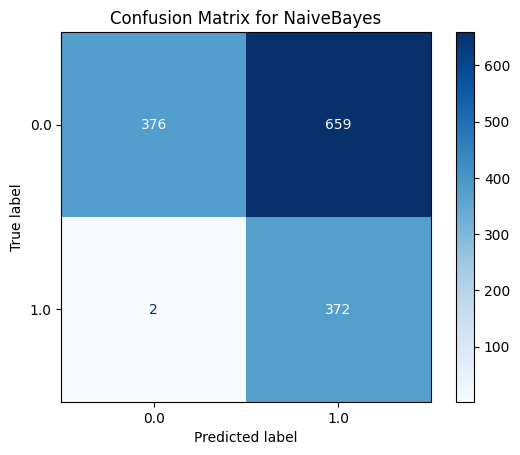

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Iterate through models, fit on training data, and display confusion matrix for test data
for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    
    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    # Plot the confusion matrix
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


Training and evaluating RandomForest...
Training and evaluating XGBoost...
Training and evaluating LGBM...
Training and evaluating DecisionTree...
Training and evaluating KNN...
Training and evaluating SVC...
Training and evaluating LogisticRegression...
Training and evaluating CatBoost...
Training and evaluating GradientBoosting...
Training and evaluating AdaBoost...
Training and evaluating NaiveBayes...


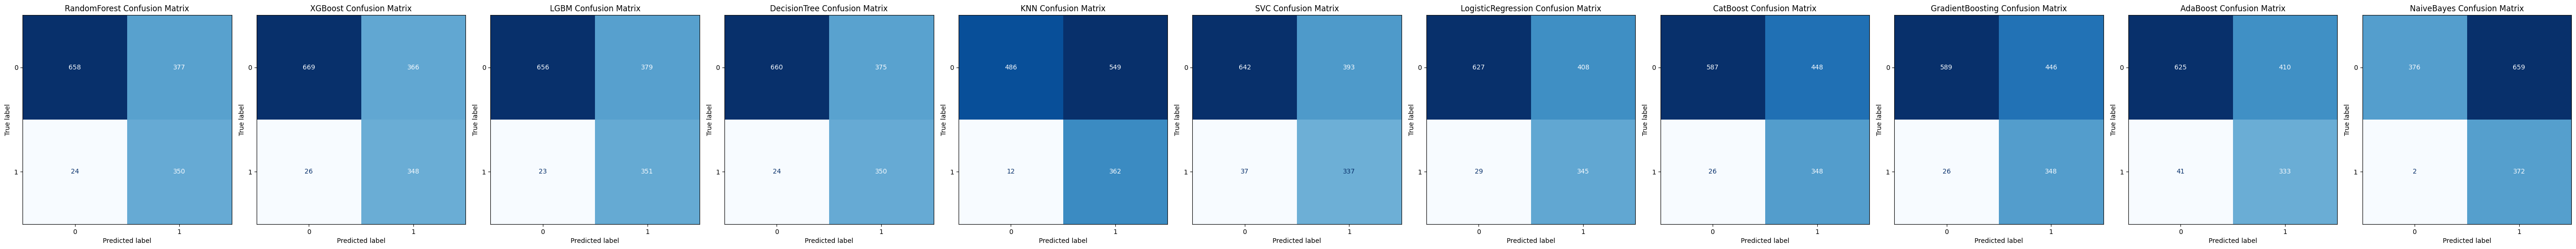

In [46]:


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set up subplots
num_models = len(models)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))

# Plot confusion matrix for each model in a subplot
for ax, (model_name, model) in zip(axes, models.items()):
    print(f"Training and evaluating {model_name}...")
    
    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Plot confusion matrix in the current subplot
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion Matrix")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler

# Standardize features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape to 3D input (samples, features, channels)
X_train_reshaped = X_train_scaled.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(-1, X_test.shape[1], 1)

# Define CNN model
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train_reshaped, y_train, epochs=12, batch_size=32, validation_data=(X_test_reshaped, y_test))


Epoch 1/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.7460 - loss: 0.5361 - val_accuracy: 0.7197 - val_loss: 0.5070
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.8856 - loss: 0.2506 - val_accuracy: 0.7679 - val_loss: 0.4759
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9563 - loss: 0.1001 - val_accuracy: 0.7630 - val_loss: 0.5298
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 267ms/step - accuracy: 0.9715 - loss: 0.0627 - val_accuracy: 0.7729 - val_loss: 0.5217
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9809 - loss: 0.0429 - val_accuracy: 0.7381 - val_loss: 0.6062
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9751 - loss: 0.0432 - val_accuracy: 0.7644 - val_loss: 0.6137
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9848 - loss: 0.0311 - val_accuracy: 0.7615 - val_loss: 0.6667
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9817 - loss: 0.0315

In [51]:
from sklearn.metrics import classification_report

# Train the model
model_cnn.fit(X_train_reshaped, y_train, epochs=12, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Predict on the test set
y_pred = model_cnn.predict(X_test_reshaped)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print(classification_report(y_test, y_pred_labels, target_names=["Class 0", "Class 1"]))


Epoch 1/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9959 - loss: 0.0094 - val_accuracy: 0.7566 - val_loss: 1.1623
Epoch 2/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9946 - loss: 0.0103 - val_accuracy: 0.7537 - val_loss: 1.2187
Epoch 3/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9962 - loss: 0.0090 - val_accuracy: 0.7445 - val_loss: 1.2352
Epoch 4/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9954 - loss: 0.0080 - val_accuracy: 0.7594 - val_loss: 1.2240
Epoch 5/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9961 - loss: 0.0079 - val_accuracy: 0.7516 - val_loss: 1.2245
Epoch 6/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9966 - loss: 0.0072 - val_accuracy: 0.7544 - val_loss: 1.2848
Epoch 7/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9946 - loss: 0.0086 - val_accuracy: 0.7459 - val_loss: 1.2688
Epoch 8/12
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9960 - loss: 0.0077 - 

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape to 3D input (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(-1, X_test.shape[1], 1)

# Define LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    Dropout(0.0001),
    Dense(124, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train_reshaped, y_train, epochs=15, batch_size=62, validation_data=(X_test_reshaped, y_test))

# Predict on the test set
y_pred = model_lstm.predict(X_test_reshaped)
y_pred_labels = (y_pred > 0.5).astype(int)

# Print classification report with F1 score, precision, and recall
print(classification_report(y_test, y_pred_labels, target_names=["Class 0", "Class 1"]))


Epoch 1/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7063 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7492 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7273 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7372 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7299 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7321 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7335 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 8/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7396 - loss: nan - val_accuracy: 0.7346 - val_loss: nan
Epoch 9/15
91/91 ━━━━━━━━━━━━━━━

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the MLP model
model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.003),  # Dropout layer for regularization
    Dense(64, activation='relu'),
    Dropout(0.03),
    Dense(1, activation='sigmoid')
])

# Compile the model with additional metrics
model_mlp.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()])

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model_mlp.fit(X_train, y_train, 
                        epochs=15, 
                        batch_size=64 ,
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping])

# Predict on the test set
y_pred_mlp = (model_mlp.predict(X_test) > 0.6).astype("int32")

# Print a classification report for detailed metrics
print(classification_report(y_test, y_pred_mlp, target_names=["Class 0", "Class 1"]))


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7524 - loss: 0.5120 - precision_1: 0.5110 - recall_1: 0.2153 - val_accuracy: 0.7921 - val_loss: 0.4398 - val_precision_1: 0.6667 - val_recall_1: 0.4332
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8037 - loss: 0.4054 - precision_1: 0.6612 - recall_1: 0.5373 - val_accuracy: 0.7921 - val_loss: 0.4306 - val_precision_1: 0.6337 - val_recall_1: 0.5134
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8587 - loss: 0.3339 - precision_1: 0.7825 - recall_1: 0.6332 - val_accuracy: 0.7878 - val_loss: 0.4307 - val_precision_1: 0.5959 - val_recall_1: 0.6230
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9483 - loss: 0.1779 - precision_1: 0.9291 - recall_1: 0.8773 - val_accuracy: 0.7580 - val_loss: 0.5061 - val_precision_1: 0.5340 - val_recall_1: 0.6925
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.0755 - precision_1: 0.9690 - recall_1: 0.9585 - val_accur